# Copyright & Acknowledgements

# Time Series Forecasting Project

# Setup

## Load Libraries

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import os

import IPython
import IPython.display

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow.data.Dataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX


from prophet import Prophet

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Set Plotting Styles
#plt.style.use('ggplot')

## Load Dataset

In [3]:
# Define location of datasets
path = "C:\\Users\\coope\\Data_Science\\Datasets\\Energy"

# Load in data
energy = pd.read_csv(path + '\hrl_load_metered.csv', index_col=[0], parse_dates=[0])
energy_t1 = pd.read_csv(path + '\hrl_load_metered - test1.csv', index_col=[0], parse_dates=[0])
energy_t2 = pd.read_csv(path + '\hrl_load_metered - test2.csv', index_col=[0], parse_dates=[0])
energy_t3 = pd.read_csv(path + '\hrl_load_metered - test3.csv', index_col=[1], parse_dates=[1])
energy_t4 = pd.read_csv(path + '\hrl_load_metered - test4.csv', index_col=[0], parse_dates=[0])
energy_t5 = pd.read_csv(path + '\hrl_load_metered - test5.csv', index_col=[0], parse_dates=[0])

# Preprocessing & Cleanup

In [6]:
print(energy.head(10))
print(energy_t1.head(10))
print(energy_t2.head(10))
print(energy_t3.head(10))
print(energy_t4.head(10))
print(energy_t5.head(10))

                       nerc_region mkt_region zone load_area        mw  \
datetime_beginning_ept                                                   
2016-01-01 00:00:00            RFC       WEST  AEP    AEPAPT  4064.992   
2016-01-01 01:00:00            RFC       WEST  AEP    AEPAPT  4023.104   
2016-01-01 02:00:00            RFC       WEST  AEP    AEPAPT  4009.598   
2016-01-01 03:00:00            RFC       WEST  AEP    AEPAPT  4004.521   
2016-01-01 04:00:00            RFC       WEST  AEP    AEPAPT  4080.944   
2016-01-01 05:00:00            RFC       WEST  AEP    AEPAPT  4177.135   
2016-01-01 06:00:00            RFC       WEST  AEP    AEPAPT  4316.690   
2016-01-01 07:00:00            RFC       WEST  AEP    AEPAPT  4471.222   
2016-01-01 08:00:00            RFC       WEST  AEP    AEPAPT  4574.792   
2016-01-01 09:00:00            RFC       WEST  AEP    AEPAPT  4683.739   

                        is_verified  
datetime_beginning_ept               
2016-01-01 00:00:00            True

In [7]:
# Remove excess column
energy_t3 = energy_t3.drop(['datetime_beginning_utc'], axis = 1)

# Combine datasets
total_energy = pd.concat([energy, energy_t1, energy_t2, energy_t3, energy_t4, energy_t5])

total_energy.head(10)

,nerc_region,mkt_region,zone,load_area,mw,is_verified
datetime_beginning_ept,,,,,,
2016-01-01 00:00:00,RFC,WEST,AEP,AEPAPT,4064.992,True
2016-01-01 01:00:00,RFC,WEST,AEP,AEPAPT,4023.104,True
2016-01-01 02:00:00,RFC,WEST,AEP,AEPAPT,4009.598,True
2016-01-01 03:00:00,RFC,WEST,AEP,AEPAPT,4004.521,True
2016-01-01 04:00:00,RFC,WEST,AEP,AEPAPT,4080.944,True
2016-01-01 05:00:00,RFC,WEST,AEP,AEPAPT,4177.135,True
2016-01-01 06:00:00,RFC,WEST,AEP,AEPAPT,4316.690,True
2016-01-01 07:00:00,RFC,WEST,AEP,AEPAPT,4471.222,True
2016-01-01 08:00:00,RFC,WEST,AEP,AEPAPT,4574.792,True


In [9]:
# Drop unnessesary columns
aep_df = total_energy.drop(columns = ["nerc_region", "zone", "mkt_region", "load_area", "is_verified"])

# Rename Index
aep_df.index.names = ["Datetime"]

# Sort Data
aep_df.sort_index(inplace = True)

# Identify Duplicate Indices
duplicate_index = aep_df[aep_df.index.duplicated()]
print(aep_df.loc[duplicate_index.index.values, :])

# Replace Duplicates with Mean Value
aep_df = aep_df.groupby('Datetime').agg(np.mean)

#Set Datetime Index Frequency
aep_df = aep_df.asfreq('H')

# Determine # of Missing Values
print('# of Missing df_MW Values:{}'.format(len(aep_df[aep_df['mw'].isna()])))

# Impute Missing Values
aep_df['mw'] = aep_df['mw'].interpolate(limit_area = 'inside', limit = None)

                           mw
Datetime                     
2016-11-06 01:00:00  3608.340
2016-11-06 01:00:00  3608.197
2017-11-05 01:00:00  3296.872
2017-11-05 01:00:00  3251.448
2018-11-04 01:00:00  4073.050
2018-11-04 01:00:00  4089.423
2019-11-03 01:00:00  4067.316
2019-11-03 01:00:00  4053.021
2020-11-01 01:00:00  3704.506
2020-11-01 01:00:00  3656.434
2021-11-07 01:00:00  4042.513
2021-11-07 01:00:00  4081.986
2022-11-06 01:00:00  3091.819
2022-11-06 01:00:00  3028.478
# of Missing df_MW Values:8


## EDA

In [10]:
aep_df.head(10)

,mw
Datetime,
2016-01-01 00:00:00,4064.992
2016-01-01 01:00:00,4023.104
2016-01-01 02:00:00,4009.598
2016-01-01 03:00:00,4004.521
2016-01-01 04:00:00,4080.944
2016-01-01 05:00:00,4177.135
2016-01-01 06:00:00,4316.690
2016-01-01 07:00:00,4471.222
2016-01-01 08:00:00,4574.792


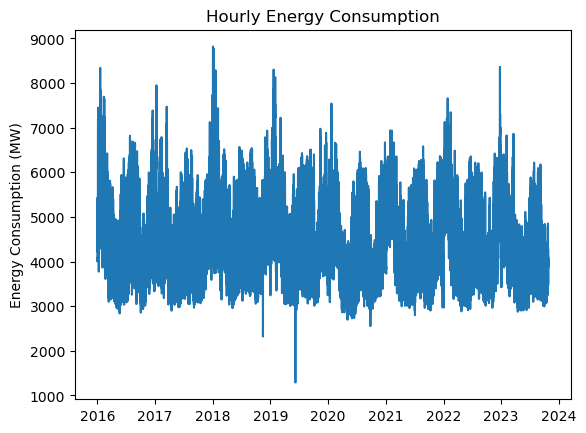

In [11]:
## Visualize Energy Consumption
plt.plot(aep_df.index, aep_df['mw'])
plt.title('Hourly Energy Consumption')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [12]:
aep_df.describe()

,mw
count,68520.00000
mean,4442.80571
std,836.47753
min,1289.92300
25%,3826.72700
50%,4306.42800
75%,4984.94750
max,8820.49600


## Feature Engineering

### Time

In [13]:
date_time = pd.to_datetime(aep_df.index, format = '%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24 * 60 * 60
year = (365.2425) * day

aep_df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
aep_df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
aep_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
aep_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

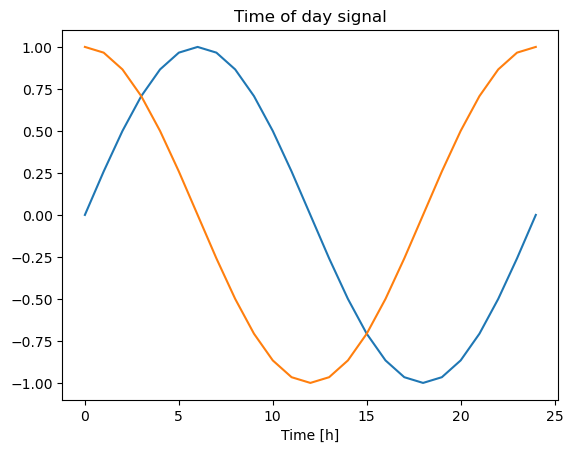

In [14]:
plt.plot(np.array(aep_df['Day sin'])[:25])
plt.plot(np.array(aep_df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

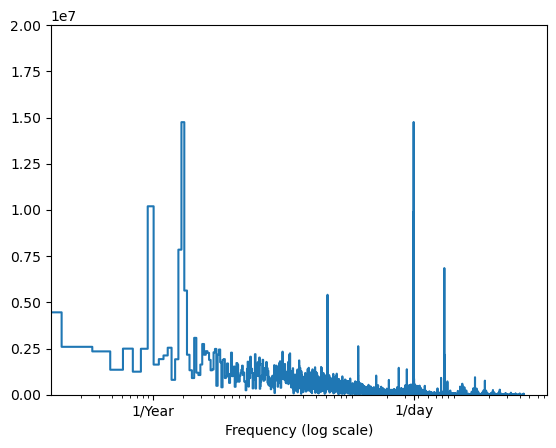

In [15]:
fft = tf.signal.rfft(aep_df['mw'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(aep_df['mw'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 20000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## Split Data

### Split for Neural Network Models

In [16]:
df = aep_df

# Split Between Test, Train, and Validation
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n * 0.7)]
val_df = df[int(n * 0.7):int(n * 0.9)]
test_df = df[int(n * 0.9):]

num_features = df.shape[1]

In [18]:
train_df

,mw,Day sin,Day cos,Year sin,Year cos
Datetime,,,,,
2016-01-01 00:00:00,4064.992,-1.407890e-12,1.000000,-0.002666,0.999996
2016-01-01 01:00:00,4023.104,2.588190e-01,0.965926,-0.001950,0.999998
2016-01-01 02:00:00,4009.598,5.000000e-01,0.866025,-0.001233,0.999999
2016-01-01 03:00:00,4004.521,7.071068e-01,0.707107,-0.000516,1.000000
2016-01-01 04:00:00,4080.944,8.660254e-01,0.500000,0.000201,1.000000
...,...,...,...,...,...
2021-06-21 07:00:00,4118.641,9.659258e-01,-0.258819,0.182983,-0.983116
2021-06-21 08:00:00,4455.221,8.660254e-01,-0.500000,0.182278,-0.983247
2021-06-21 09:00:00,4783.663,7.071068e-01,-0.707107,0.181573,-0.983377


In [53]:
val_df

,mw,Day sin,Day cos,Year sin,Year cos
Datetime,,,,,
2021-06-21 12:00:00,1.356234,-0.000224,-1.414228,0.172329,-1.402351
2021-06-21 13:00:00,1.468946,-0.366246,-1.366041,0.171331,-1.402533
2021-06-21 14:00:00,1.618058,-0.707323,-1.224762,0.170333,-1.402714
2021-06-21 15:00:00,1.607706,-1.000214,-1.000019,0.169334,-1.402895
2021-06-21 16:00:00,1.498044,-1.224956,-0.707129,0.168336,-1.403075
...,...,...,...,...,...
2023-01-13 07:00:00,0.717805,1.365787,-0.366051,0.218894,1.377950
2023-01-13 08:00:00,0.801264,1.224508,-0.707129,0.219886,1.377734
2023-01-13 09:00:00,0.790440,0.999766,-1.000019,0.220877,1.377517


In [54]:
test_df

,mw,Day sin,Day cos,Year sin,Year cos
Datetime,,,,,
2023-01-13 12:00:00,0.675790,-0.000224,-1.414228,0.223849,1.376862
2023-01-13 13:00:00,0.690501,-0.366246,-1.366041,0.224840,1.376642
2023-01-13 14:00:00,0.672368,-0.707323,-1.224762,0.225830,1.376422
2023-01-13 15:00:00,0.710108,-1.000214,-1.000019,0.226820,1.376201
2023-01-13 16:00:00,0.858894,-1.224956,-0.707129,0.227810,1.375979
...,...,...,...,...,...
2023-10-25 19:00:00,-0.486561,-1.366235,0.365992,-1.378001,0.561508
2023-10-25 20:00:00,-0.584124,-1.224956,0.707070,-1.377594,0.562438
2023-10-25 21:00:00,-0.734173,-1.000214,0.999960,-1.377186,0.563369


## Normalize Data

In [19]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

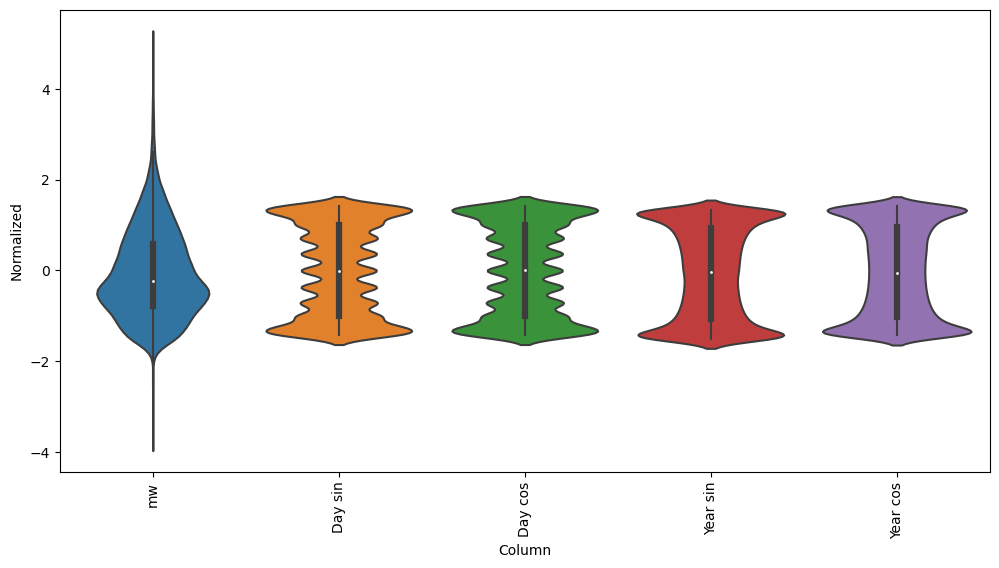

In [20]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data Windowing Functions

In [21]:
## Indexes and Offsets
# Create WindowGenerator Function

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df = train_df, val_df = val_df, test_df = test_df,
               label_columns = None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [22]:
## Split into window of inputs and labels

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [23]:
## Plot method of split window

def plot(self, model=None, plot_col='mw', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [24]:
# Method to convert to tf.data.Datasets

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [25]:
# Add properties to WindowGenerator Object

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Model Training Function

In [30]:
# Function for training models
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Forecasting 24 Hours Ahead (Multi-step Models)

## Set Window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

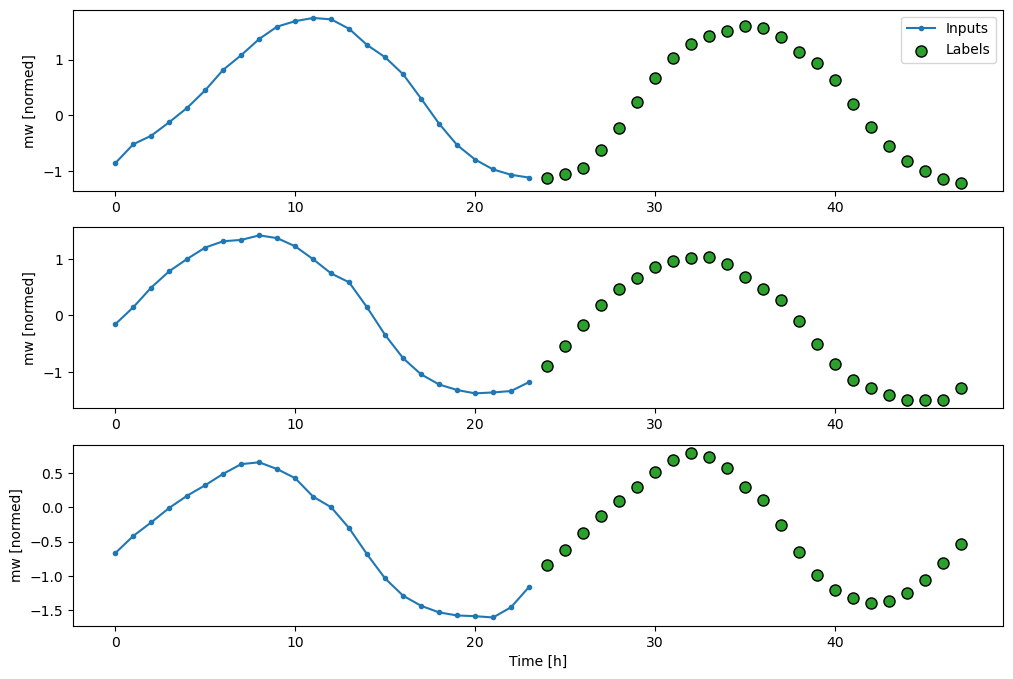

In [26]:
# Number of Predictions
OUT_STEPS = 24

multi_window = WindowGenerator(input_width = 24, # How many hours the model is given
                               label_width = OUT_STEPS,
                               shift = OUT_STEPS)

multi_window.plot()
multi_window

## Baseline Models

Repeat last hour 24 times to predict 24 hours into the future

427/427 [==============================] - 1s 1ms/step - loss: 0.9562 - mean_absolute_error: 0.5935


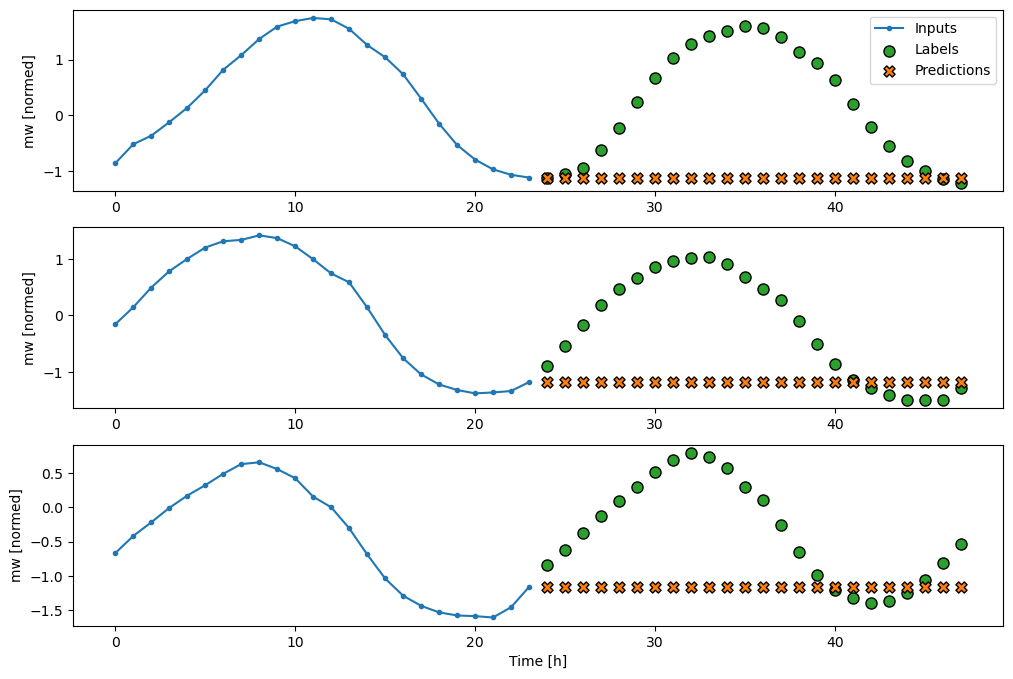

In [27]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Repeat previous 24 hours to predict 24 hours into the future

427/427 [==============================] - 1s 1ms/step - loss: 0.0535 - mean_absolute_error: 0.0787


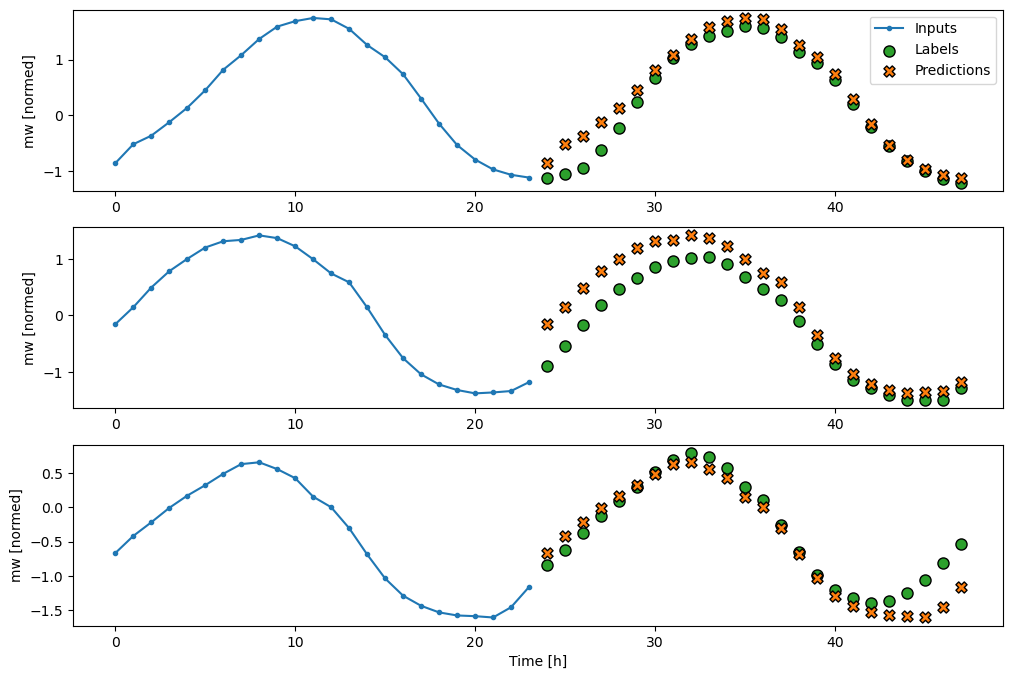

In [28]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## Single Shot Models

### Linear

427/427 [==============================] - 0s 596us/step - loss: 0.0874 - mean_absolute_error: 0.1020


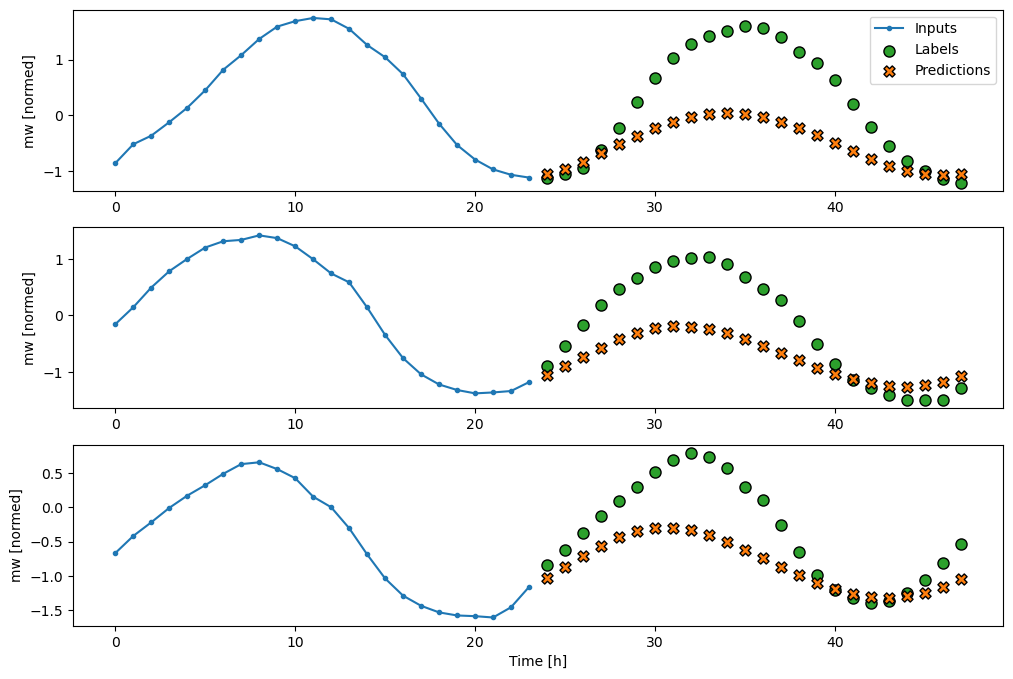

In [31]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### Dense

427/427 [==============================] - 0s 880us/step - loss: 0.0331 - mean_absolute_error: 0.0626


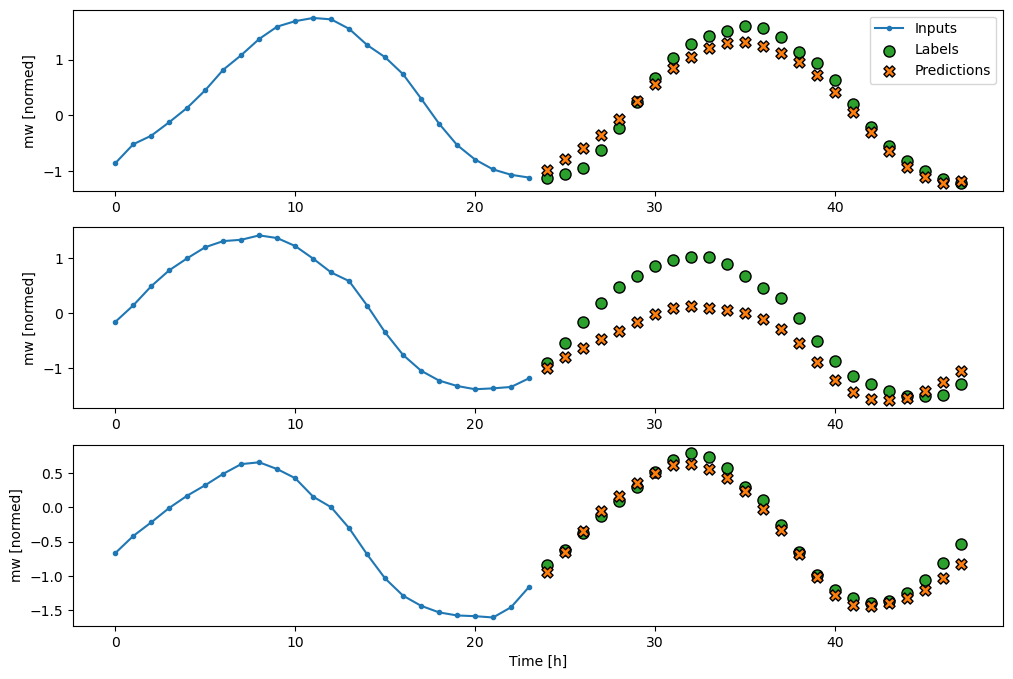

In [32]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

### CNN

427/427 [==============================] - 0s 953us/step - loss: 0.0331 - mean_absolute_error: 0.0648


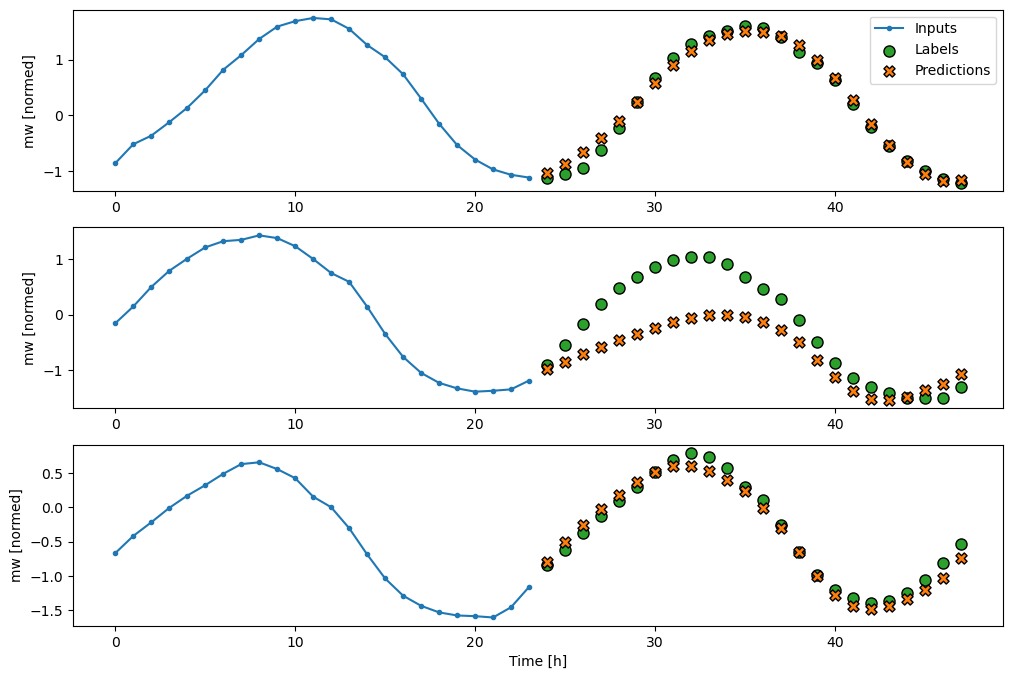

In [39]:
# Controls how many hours the model can look back to
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

### RNN

427/427 [==============================] - 1s 2ms/step - loss: 0.0245 - mean_absolute_error: 0.0622


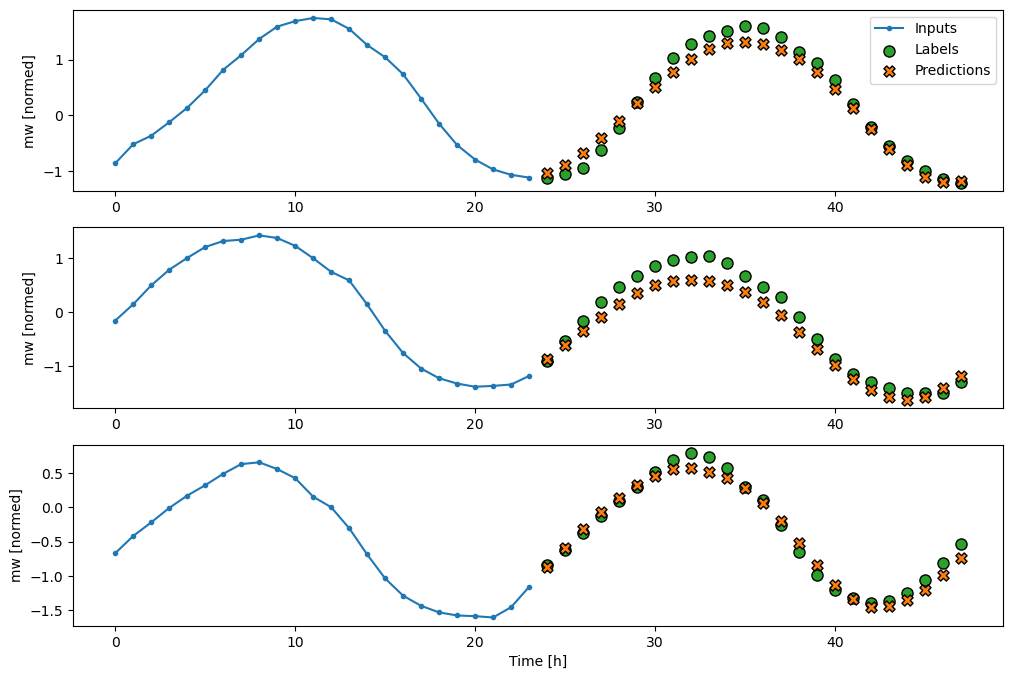

In [40]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## Autoregressive Models

### AR RNN

In [41]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [42]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [43]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [45]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

427/427 [==============================] - 2s 4ms/step - loss: 0.0308 - mean_absolute_error: 0.0760


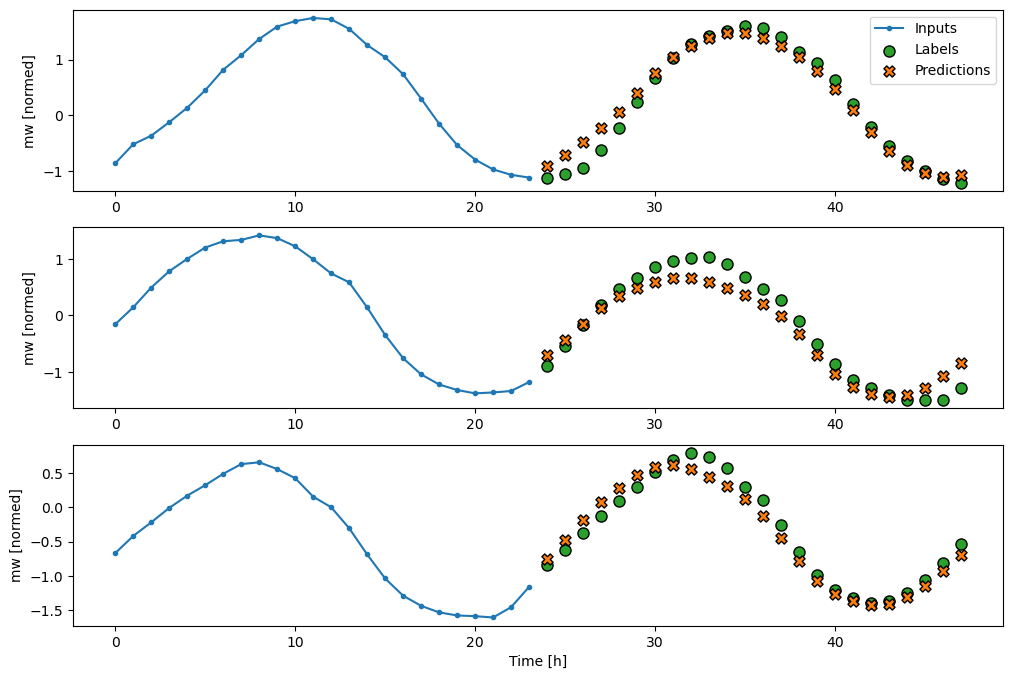

In [46]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

## Performance

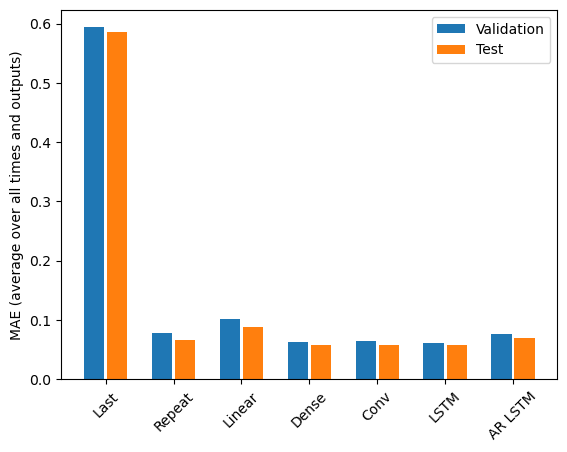

In [58]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [57]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5857
Repeat  : 0.0657
Linear  : 0.0880
Dense   : 0.0573
Conv    : 0.0585
LSTM    : 0.0577
AR LSTM : 0.0691
